In [1]:
# Cell 1: Imports
import os
import sys
import warnings
from datetime import datetime
from pathlib import Path
import logging
import json
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    precision_recall_curve,
    roc_curve,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score
)

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("✓ All imports successful")

✓ All imports successful


In [2]:
# Cell 2: Configuration Class
class ModelConfig:
    """Configuration for CatBoost model training"""
    
    # Paths
    DATA_DIR = Path("output")
    MODEL_DIR = Path("models")
    FIGURES_DIR = Path("figures")
    LOG_DIR = Path("logs")
    
    # Data files
    TRAIN_FILE = "train_processed.csv"
    VAL_FILE = "val_processed.csv"
    TEST_FILE = "test_processed.csv"
    PROD_FILE = "prod_processed.csv"
    METADATA_FILE = "preprocessing_metadata.json"
    CAT_FEATURES_FILE = "categorical_features.json"
    
    # Model files
    MODEL_FILE = "catboost_churn_model.cbm"
    MODEL_METADATA = "model_metadata.json"
    FEATURE_IMPORTANCE_FILE = "feature_importance.csv"
    
    # Data configuration
    DELIMITER = '|'
    ID_COLUMNS = ['cli_code', 'client_id', 'observation_point']
    TARGET_COLUMN = 'target_churn_3m'
    
    # CatBoost parameters - OPTIMIZED FOR IMBALANCED DATA
    CATBOOST_PARAMS = {
        'iterations': 500,
        'learning_rate': 0.05,
        'depth': 4,
        'l2_leaf_reg': 3,
        'min_data_in_leaf': 100,
        'random_strength': 1,
        'bagging_temperature': 1,
        'border_count': 128,
        
        # Loss function for imbalanced data
        'loss_function': 'Logloss',  # или 'CrossEntropy'
        'eval_metric': 'AUC',
        
        # Early stopping
        'early_stopping_rounds': 100,
        'use_best_model': True,
        
        # Other
        'random_seed': 42,
        'task_type': 'CPU',  # или 'GPU' если есть
        'verbose': 100,
        'allow_writing_files': False
    }
    
    # Class imbalance handling
    USE_CLASS_WEIGHTS = True
    USE_SCALE_POS_WEIGHT = True  # Alternative to class_weights
    
    # Threshold tuning
    TUNE_THRESHOLD = True
    THRESHOLD_METRIC = 'f1'  # 'f1', 'recall', 'precision', or custom
    
    # Evaluation
    RANDOM_SEED = 42
    
    @classmethod
    def create_directories(cls):
        """Create necessary directories"""
        for dir_path in [cls.DATA_DIR, cls.MODEL_DIR, cls.FIGURES_DIR, cls.LOG_DIR]:
            dir_path.mkdir(parents=True, exist_ok=True)
    
    @classmethod
    def get_train_path(cls):
        return cls.DATA_DIR / cls.TRAIN_FILE
    
    @classmethod
    def get_val_path(cls):
        return cls.DATA_DIR / cls.VAL_FILE
    
    @classmethod
    def get_test_path(cls):
        return cls.DATA_DIR / cls.TEST_FILE
    
    @classmethod
    def get_prod_path(cls):
        return cls.DATA_DIR / cls.PROD_FILE

# Initialize configuration
config = ModelConfig()
config.create_directories()
np.random.seed(config.RANDOM_SEED)

print("✓ Configuration initialized")
print(f"  Model will be saved to: {config.MODEL_DIR}")
print(f"  Using class imbalance handling: {config.USE_CLASS_WEIGHTS or config.USE_SCALE_POS_WEIGHT}")


✓ Configuration initialized
  Model will be saved to: models
  Using class imbalance handling: True


In [3]:
# Cell 3: Logging Setup
def setup_logging():
    """Setup logging configuration"""
    log_file = config.LOG_DIR / f"training_{datetime.now().strftime('%Y%m%d_%H%M%S')}.log"
    
    file_formatter = logging.Formatter(
        '%(asctime)s - %(name)s - %(levelname)s - %(message)s',
        datefmt='%Y-%m-%d %H:%M:%S'
    )
    console_formatter = logging.Formatter('%(levelname)s - %(message)s')
    
    file_handler = logging.FileHandler(log_file, encoding='utf-8')
    file_handler.setLevel(logging.INFO)
    file_handler.setFormatter(file_formatter)
    
    console_handler = logging.StreamHandler(sys.stdout)
    console_handler.setLevel(logging.INFO)
    console_handler.setFormatter(console_formatter)
    
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    logger.handlers = []
    
    logger.addHandler(file_handler)
    logger.addHandler(console_handler)
    
    return logging.getLogger(__name__)

logger = setup_logging()
logger.info("="*60)
logger.info("CATBOOST MODEL TRAINING - CHURN PREDICTION")
logger.info("="*60)

print("✓ Logging configured")

INFO - ============================================================
INFO - CATBOOST MODEL TRAINING - CHURN PREDICTION
INFO - ============================================================
✓ Logging configured


In [4]:
# Cell 4: Load Data
logger.info("\n" + "="*60)
logger.info("LOADING PROCESSED DATA")
logger.info("="*60)

# Load training data
logger.info(f"Loading training data from {config.get_train_path()}")
train_df = pd.read_csv(config.get_train_path(), delimiter=config.DELIMITER)
logger.info(f"  Train shape: {train_df.shape}")

# Load validation data
logger.info(f"Loading validation data from {config.get_val_path()}")
val_df = pd.read_csv(config.get_val_path(), delimiter=config.DELIMITER)
logger.info(f"  Val shape: {val_df.shape}")

# Load test data
logger.info(f"Loading test data from {config.get_test_path()}")
test_df = pd.read_csv(config.get_test_path(), delimiter=config.DELIMITER)
logger.info(f"  Test shape: {test_df.shape}")

# Load categorical features
cat_features_path = config.DATA_DIR / config.CAT_FEATURES_FILE
if cat_features_path.exists():
    with open(cat_features_path, 'r') as f:
        categorical_features = json.load(f)
    logger.info(f"✓ Loaded categorical features: {categorical_features}")
else:
    categorical_features = []
    logger.warning("⚠ No categorical features file found")

print(f"\n✓ Data loaded successfully")
print(f"  Train: {train_df.shape}")
print(f"  Val: {val_df.shape}")
print(f"  Test: {test_df.shape}")
print(f"  Categorical features: {categorical_features}")

INFO - 
INFO - LOADING PROCESSED DATA
INFO - ============================================================
INFO - Loading training data from output\train_processed.csv
INFO -   Train shape: (2153407, 125)
INFO - Loading validation data from output\val_processed.csv
INFO -   Val shape: (531880, 125)
INFO - Loading test data from output\test_processed.csv
INFO -   Test shape: (542902, 125)
INFO - ✓ Loaded categorical features: ['segment_group', 'obs_month', 'obs_quarter']

✓ Data loaded successfully
  Train: (2153407, 125)
  Val: (531880, 125)
  Test: (542902, 125)
  Categorical features: ['segment_group', 'obs_month', 'obs_quarter']


INFO - 
INFO - ANALYZING CLASS IMBALANCE
INFO - ============================================================
INFO - 
TRAIN Class Distribution:
INFO -   Class 0 (No Churn): 2,122,293 (98.56%)
INFO -   Class 1 (Churn): 31,114 (1.44%)
INFO -   Imbalance ratio: 68.21:1
INFO - 
VAL Class Distribution:
INFO -   Class 0 (No Churn): 522,447 (98.23%)
INFO -   Class 1 (Churn): 9,433 (1.77%)
INFO - 
Class Weight Calculations:
INFO -   Class 0 weight: 0.5073
INFO -   Class 1 weight: 34.6051
INFO -   Scale pos weight: 68.21

✓ Class imbalance analysis complete
  Churn rate (train): 1.44%
  Imbalance ratio: 68.2:1
  Scale pos weight: 68.21


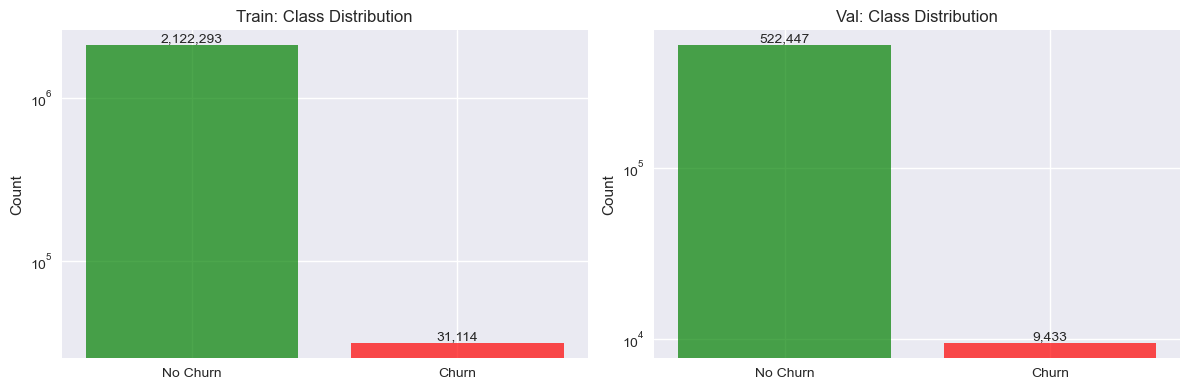

✓ Saved visualization: figures\class_distribution.png


In [5]:
# Cell 5: Analyze Class Imbalance
logger.info("\n" + "="*60)
logger.info("ANALYZING CLASS IMBALANCE")
logger.info("="*60)

# Calculate class distribution
class_dist_train = train_df[config.TARGET_COLUMN].value_counts()
churn_rate_train = train_df[config.TARGET_COLUMN].mean()

class_dist_val = val_df[config.TARGET_COLUMN].value_counts()
churn_rate_val = val_df[config.TARGET_COLUMN].mean()

logger.info(f"\nTRAIN Class Distribution:")
logger.info(f"  Class 0 (No Churn): {class_dist_train[0]:,} ({(1-churn_rate_train)*100:.2f}%)")
logger.info(f"  Class 1 (Churn): {class_dist_train[1]:,} ({churn_rate_train*100:.2f}%)")
logger.info(f"  Imbalance ratio: {class_dist_train[0]/class_dist_train[1]:.2f}:1")

logger.info(f"\nVAL Class Distribution:")
logger.info(f"  Class 0 (No Churn): {class_dist_val[0]:,} ({(1-churn_rate_val)*100:.2f}%)")
logger.info(f"  Class 1 (Churn): {class_dist_val[1]:,} ({churn_rate_val*100:.2f}%)")

# Calculate class weights
n_samples = len(train_df)
n_classes = 2
n_class_0 = class_dist_train[0]
n_class_1 = class_dist_train[1]

# Method 1: Balanced class weights
class_weight_0 = n_samples / (n_classes * n_class_0)
class_weight_1 = n_samples / (n_classes * n_class_1)

# Method 2: Scale pos weight (for use_scale_pos_weight)
scale_pos_weight = n_class_0 / n_class_1

logger.info(f"\nClass Weight Calculations:")
logger.info(f"  Class 0 weight: {class_weight_0:.4f}")
logger.info(f"  Class 1 weight: {class_weight_1:.4f}")
logger.info(f"  Scale pos weight: {scale_pos_weight:.2f}")

print(f"\n✓ Class imbalance analysis complete")
print(f"  Churn rate (train): {churn_rate_train*100:.2f}%")
print(f"  Imbalance ratio: {class_dist_train[0]/class_dist_train[1]:.1f}:1")
print(f"  Scale pos weight: {scale_pos_weight:.2f}")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Train distribution
axes[0].bar(['No Churn', 'Churn'], [class_dist_train[0], class_dist_train[1]], 
           color=['green', 'red'], alpha=0.7)
axes[0].set_title('Train: Class Distribution')
axes[0].set_ylabel('Count')
axes[0].set_yscale('log')
for i, v in enumerate([class_dist_train[0], class_dist_train[1]]):
    axes[0].text(i, v, f'{v:,}', ha='center', va='bottom')

# Val distribution
axes[1].bar(['No Churn', 'Churn'], [class_dist_val[0], class_dist_val[1]], 
           color=['green', 'red'], alpha=0.7)
axes[1].set_title('Val: Class Distribution')
axes[1].set_ylabel('Count')
axes[1].set_yscale('log')
for i, v in enumerate([class_dist_val[0], class_dist_val[1]]):
    axes[1].text(i, v, f'{v:,}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved visualization: {config.FIGURES_DIR / 'class_distribution.png'}")


In [6]:
# Cell 6: Prepare Data for Training
logger.info("\n" + "="*60)
logger.info("PREPARING DATA FOR TRAINING")
logger.info("="*60)

# Separate features and target
def prepare_dataset(df, dataset_name='train'):
    """Prepare dataset by separating features and target"""
    logger.info(f"\nPreparing {dataset_name} dataset...")
    
    # Drop ID columns and target
    feature_cols = [col for col in df.columns 
                   if col not in config.ID_COLUMNS + [config.TARGET_COLUMN]]
    
    X = df[feature_cols].copy()
    y = df[config.TARGET_COLUMN].copy() if config.TARGET_COLUMN in df.columns else None
    
    # CRITICAL: Convert categorical features to string type for CatBoost
    for cat_feat in categorical_features:
        if cat_feat in X.columns:
            # Convert to string, handling NaN values
            X[cat_feat] = X[cat_feat].astype(str)
            # Replace 'nan' string with actual category if needed
            X[cat_feat] = X[cat_feat].replace('nan', 'missing')
            logger.info(f"  Converted {cat_feat} to string: {X[cat_feat].nunique()} unique values")
    
    # Get indices of categorical features in the feature list
    cat_feature_indices = [i for i, col in enumerate(feature_cols) 
                          if col in categorical_features]
    
    logger.info(f"  Features: {len(feature_cols)}")
    logger.info(f"  Categorical features: {len(cat_feature_indices)}")
    if y is not None:
        logger.info(f"  Samples: {len(X)}")
        logger.info(f"  Target distribution: {y.value_counts().to_dict()}")
    
    return X, y, cat_feature_indices

# Prepare train, val, test
X_train, y_train, cat_indices = prepare_dataset(train_df, 'train')
X_val, y_val, _ = prepare_dataset(val_df, 'validation')
X_test, y_test, _ = prepare_dataset(test_df, 'test')

print(f"\n✓ Data preparation complete")
print(f"  X_train shape: {X_train.shape}")
print(f"  X_val shape: {X_val.shape}")
print(f"  X_test shape: {X_test.shape}")
print(f"  Categorical feature indices: {cat_indices}")

INFO - 
INFO - PREPARING DATA FOR TRAINING
INFO - ============================================================
INFO - 
Preparing train dataset...
INFO -   Converted segment_group to string: 3 unique values
INFO -   Converted obs_month to string: 12 unique values
INFO -   Converted obs_quarter to string: 4 unique values
INFO -   Features: 121
INFO -   Categorical features: 3
INFO -   Samples: 2153407
INFO -   Target distribution: {0: 2122293, 1: 31114}
INFO - 
Preparing validation dataset...
INFO -   Converted segment_group to string: 3 unique values
INFO -   Converted obs_month to string: 4 unique values
INFO -   Converted obs_quarter to string: 2 unique values
INFO -   Features: 121
INFO -   Categorical features: 3
INFO -   Samples: 531880
INFO -   Target distribution: {0: 522447, 1: 9433}
INFO - 
Preparing test dataset...
INFO -   Converted segment_group to string: 3 unique values
INFO -   Converted obs_month to string: 4 unique values
INFO -   Converted obs_quarter to string: 2 uniq

In [7]:
# Cell 7: Create CatBoost Pools with Class Weights
logger.info("\n" + "="*60)
logger.info("CREATING CATBOOST POOLS")
logger.info("="*60)

# Calculate sample weights for imbalanced data
if config.USE_CLASS_WEIGHTS:
    logger.info("Using class weights for imbalanced data...")
    
    # Create sample weights: assign higher weight to minority class
    train_weights = np.ones(len(y_train))
    train_weights[y_train == 1] = class_weight_1
    train_weights[y_train == 0] = class_weight_0
    
    logger.info(f"  Class 0 samples get weight: {class_weight_0:.4f}")
    logger.info(f"  Class 1 samples get weight: {class_weight_1:.4f}")
else:
    train_weights = None
    logger.info("Not using class weights")

# Create CatBoost Pool objects
train_pool = Pool(
    data=X_train,
    label=y_train,
    cat_features=cat_indices,
    weight=train_weights
)

val_pool = Pool(
    data=X_val,
    label=y_val,
    cat_features=cat_indices
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    cat_features=cat_indices
)

logger.info("✓ CatBoost Pools created successfully")
print(f"\n✓ CatBoost Pools created")
print(f"  Train pool: {train_pool.num_row()} samples")
print(f"  Val pool: {val_pool.num_row()} samples")
print(f"  Test pool: {test_pool.num_row()} samples")
if train_weights is not None:
    print(f"  Using sample weights: Yes")

INFO - 
INFO - CREATING CATBOOST POOLS
INFO - ============================================================
INFO - Using class weights for imbalanced data...
INFO -   Class 0 samples get weight: 0.5073
INFO -   Class 1 samples get weight: 34.6051
INFO - ✓ CatBoost Pools created successfully

✓ CatBoost Pools created
  Train pool: 2153407 samples
  Val pool: 531880 samples
  Test pool: 542902 samples
  Using sample weights: Yes


In [8]:
# Cell 8: Initialize and Train CatBoost Model
logger.info("\n" + "="*60)
logger.info("TRAINING CATBOOST MODEL")
logger.info("="*60)

# Update parameters with scale_pos_weight if using
catboost_params = config.CATBOOST_PARAMS.copy()

if config.USE_SCALE_POS_WEIGHT and not config.USE_CLASS_WEIGHTS:
    catboost_params['scale_pos_weight'] = scale_pos_weight
    logger.info(f"Using scale_pos_weight: {scale_pos_weight:.2f}")

# Log all parameters
logger.info("\nModel Parameters:")
for key, value in catboost_params.items():
    logger.info(f"  {key}: {value}")

# Initialize model
model = CatBoostClassifier(**catboost_params)

# Train model
logger.info("\n" + "="*60)
logger.info("STARTING TRAINING...")
logger.info("="*60)

model.fit(
    train_pool,
    eval_set=val_pool,
    plot=False,
    verbose_eval=100
)

logger.info("\n✓ Model training complete!")
logger.info(f"  Best iteration: {model.best_iteration_}")
logger.info(f"  Best score: {model.best_score_}")

print(f"\n✓ Model training complete!")
print(f"  Best iteration: {model.best_iteration_}")
print(f"  Best validation AUC: {model.best_score_['validation']['AUC']:.4f}")


INFO - 
INFO - TRAINING CATBOOST MODEL
INFO - ============================================================
INFO - 
Model Parameters:
INFO -   iterations: 500
INFO -   learning_rate: 0.05
INFO -   depth: 4
INFO -   l2_leaf_reg: 3
INFO -   min_data_in_leaf: 100
INFO -   random_strength: 1
INFO -   bagging_temperature: 1
INFO -   border_count: 128
INFO -   loss_function: Logloss
INFO -   eval_metric: AUC
INFO -   early_stopping_rounds: 100
INFO -   use_best_model: True
INFO -   random_seed: 42
INFO -   task_type: CPU
INFO -   verbose: 100
INFO -   allow_writing_files: False
INFO - 
INFO - STARTING TRAINING...
INFO - ============================================================
0:	test: 0.7971818	best: 0.7971818 (0)	total: 805ms	remaining: 6m 41s
100:	test: 0.8948355	best: 0.8948355 (100)	total: 1m 9s	remaining: 4m 34s
200:	test: 0.9006896	best: 0.9006896 (200)	total: 2m 22s	remaining: 3m 31s
300:	test: 0.9037392	best: 0.9037392 (300)	total: 3m 36s	remaining: 2m 23s
400:	test: 0.9055508	bes

In [9]:
# Cell 9: Evaluate on Validation Set
logger.info("\n" + "="*60)
logger.info("VALIDATION SET EVALUATION")
logger.info("="*60)

# Get predictions
y_val_pred_proba = model.predict_proba(val_pool)[:, 1]
y_val_pred = model.predict(val_pool)

# Calculate metrics
val_auc = roc_auc_score(y_val, y_val_pred_proba)
val_gini = 2 * val_auc - 1  # GINI coefficient
val_prauc = average_precision_score(y_val, y_val_pred_proba)
val_f1 = f1_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred)
val_recall = recall_score(y_val, y_val_pred)

logger.info(f"\nValidation Metrics (default threshold=0.5):")
logger.info(f"  ROC-AUC: {val_auc:.4f}")
logger.info(f"  GINI: {val_gini:.4f}")
logger.info(f"  PR-AUC: {val_prauc:.4f}")
logger.info(f"  F1 Score: {val_f1:.4f}")
logger.info(f"  Precision: {val_precision:.4f}")
logger.info(f"  Recall: {val_recall:.4f}")

# Confusion matrix
cm = confusion_matrix(y_val, y_val_pred)
logger.info(f"\nConfusion Matrix:")
logger.info(f"  TN: {cm[0,0]:,}, FP: {cm[0,1]:,}")
logger.info(f"  FN: {cm[1,0]:,}, TP: {cm[1,1]:,}")

print(f"\n✓ Validation evaluation complete")
print(f"  ROC-AUC: {val_auc:.4f}")
print(f"  GINI: {val_gini:.4f}")
print(f"  PR-AUC: {val_prauc:.4f}")
print(f"  F1: {val_f1:.4f}, Precision: {val_precision:.4f}, Recall: {val_recall:.4f}")

# Classification report
print(f"\nClassification Report (threshold=0.5):")
print(classification_report(y_val, y_val_pred, target_names=['No Churn', 'Churn']))


INFO - 
INFO - VALIDATION SET EVALUATION
INFO - ============================================================
INFO - 
Validation Metrics (default threshold=0.5):
INFO -   ROC-AUC: 0.9066
INFO -   GINI: 0.8132
INFO -   PR-AUC: 0.2160
INFO -   F1 Score: 0.1327
INFO -   Precision: 0.0720
INFO -   Recall: 0.8467
INFO - 
Confusion Matrix:
INFO -   TN: 419,482, FP: 102,965
INFO -   FN: 1,446, TP: 7,987

✓ Validation evaluation complete
  ROC-AUC: 0.9066
  GINI: 0.8132
  PR-AUC: 0.2160
  F1: 0.1327, Precision: 0.0720, Recall: 0.8467

Classification Report (threshold=0.5):
              precision    recall  f1-score   support

    No Churn       1.00      0.80      0.89    522447
       Churn       0.07      0.85      0.13      9433

    accuracy                           0.80    531880
   macro avg       0.53      0.82      0.51    531880
weighted avg       0.98      0.80      0.88    531880



INFO - 
INFO - THRESHOLD TUNING FOR OPTIMAL PERFORMANCE
INFO - ============================================================
INFO - Finding optimal threshold based on f1...
INFO - ✓ Optimal threshold found: 0.880
INFO -   F1 score at optimal threshold: 0.3003
INFO - 
Metrics at optimal threshold (0.880):
INFO -   F1 Score: 0.3003
INFO -   Precision: 0.2735
INFO -   Recall: 0.3330
INFO -   Confusion Matrix:
INFO -     TN: 514,104, FP: 8,343
INFO -     FN: 6,292, TP: 3,141

✓ Optimal threshold: 0.880
  F1: 0.3003
  Precision: 0.2735
  Recall: 0.3330


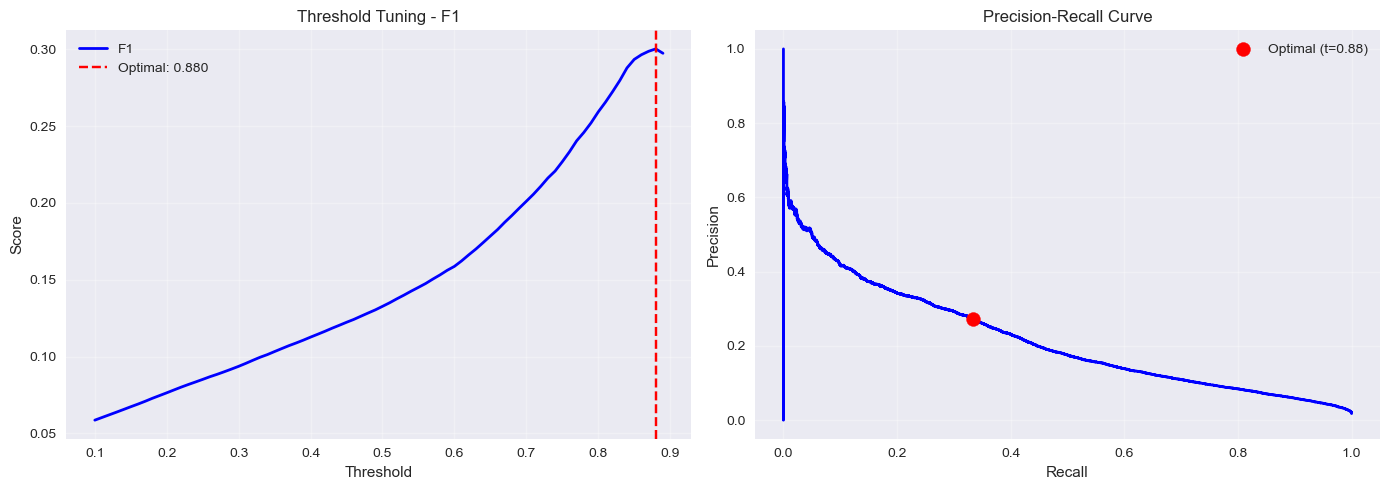

✓ Saved: figures\threshold_tuning.png


In [10]:
# Cell 10: Threshold Tuning (CRITICAL for Imbalanced Data!)
logger.info("\n" + "="*60)
logger.info("THRESHOLD TUNING FOR OPTIMAL PERFORMANCE")
logger.info("="*60)

def find_optimal_threshold(y_true, y_pred_proba, metric='f1'):
    """Find optimal threshold based on specified metric"""
    thresholds = np.arange(0.1, 0.9, 0.01)
    scores = []
    
    for threshold in thresholds:
        y_pred_threshold = (y_pred_proba >= threshold).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_true, y_pred_threshold)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred_threshold)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred_threshold)
        elif metric == 'balanced':
            # Balance between precision and recall
            prec = precision_score(y_true, y_pred_threshold)
            rec = recall_score(y_true, y_pred_threshold)
            score = 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0
        
        scores.append(score)
    
    optimal_idx = np.argmax(scores)
    optimal_threshold = thresholds[optimal_idx]
    optimal_score = scores[optimal_idx]
    
    return optimal_threshold, optimal_score, thresholds, scores

# Find optimal threshold
logger.info(f"Finding optimal threshold based on {config.THRESHOLD_METRIC}...")

optimal_threshold, optimal_score, all_thresholds, all_scores = find_optimal_threshold(
    y_val, y_val_pred_proba, metric=config.THRESHOLD_METRIC
)

logger.info(f"✓ Optimal threshold found: {optimal_threshold:.3f}")
logger.info(f"  {config.THRESHOLD_METRIC.upper()} score at optimal threshold: {optimal_score:.4f}")

# Evaluate with optimal threshold
y_val_pred_optimal = (y_val_pred_proba >= optimal_threshold).astype(int)

optimal_f1 = f1_score(y_val, y_val_pred_optimal)
optimal_precision = precision_score(y_val, y_val_pred_optimal)
optimal_recall = recall_score(y_val, y_val_pred_optimal)
optimal_cm = confusion_matrix(y_val, y_val_pred_optimal)

logger.info(f"\nMetrics at optimal threshold ({optimal_threshold:.3f}):")
logger.info(f"  F1 Score: {optimal_f1:.4f}")
logger.info(f"  Precision: {optimal_precision:.4f}")
logger.info(f"  Recall: {optimal_recall:.4f}")
logger.info(f"  Confusion Matrix:")
logger.info(f"    TN: {optimal_cm[0,0]:,}, FP: {optimal_cm[0,1]:,}")
logger.info(f"    FN: {optimal_cm[1,0]:,}, TP: {optimal_cm[1,1]:,}")

print(f"\n✓ Optimal threshold: {optimal_threshold:.3f}")
print(f"  F1: {optimal_f1:.4f}")
print(f"  Precision: {optimal_precision:.4f}")
print(f"  Recall: {optimal_recall:.4f}")

# Visualize threshold tuning
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Threshold vs Metrics
axes[0].plot(all_thresholds, all_scores, 'b-', linewidth=2, label=config.THRESHOLD_METRIC.upper())
axes[0].axvline(optimal_threshold, color='r', linestyle='--', 
               label=f'Optimal: {optimal_threshold:.3f}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Score')
axes[0].set_title(f'Threshold Tuning - {config.THRESHOLD_METRIC.upper()}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Precision-Recall Curve
precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_val, y_val_pred_proba)
axes[1].plot(recall_curve, precision_curve, 'b-', linewidth=2)
axes[1].scatter([optimal_recall], [optimal_precision], color='r', s=100, 
               label=f'Optimal (t={optimal_threshold:.2f})', zorder=5)
axes[1].set_xlabel('Recall')
axes[1].set_ylabel('Precision')
axes[1].set_title('Precision-Recall Curve')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'threshold_tuning.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {config.FIGURES_DIR / 'threshold_tuning.png'}")


INFO - 
INFO - ROC CURVE ANALYSIS
INFO - ============================================================


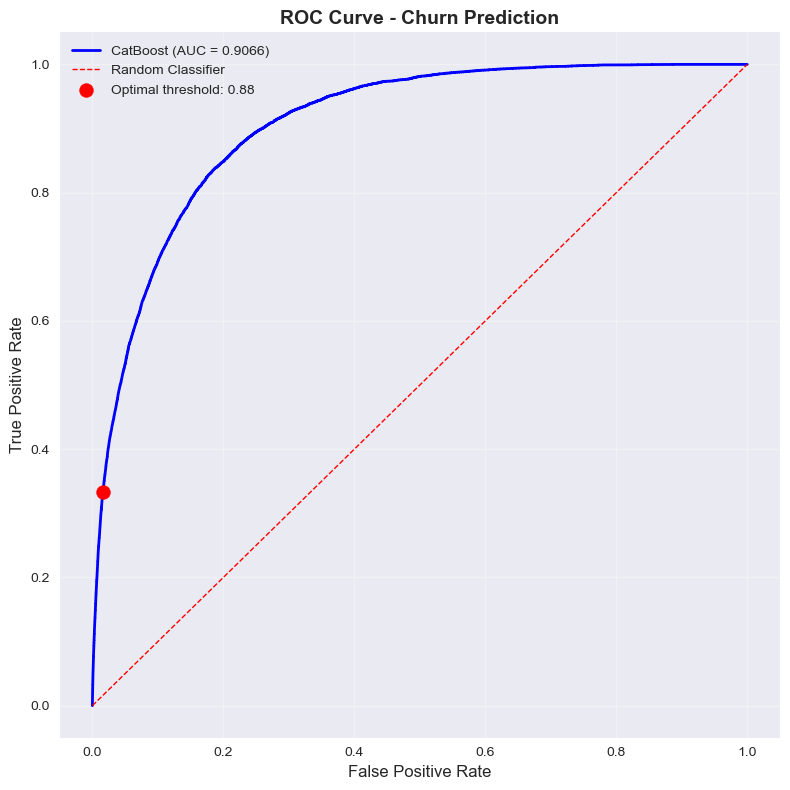

INFO - ✓ ROC curve saved
✓ Saved: figures\roc_curve.png


In [11]:
# Cell 11: ROC Curve Visualization
logger.info("\n" + "="*60)
logger.info("ROC CURVE ANALYSIS")
logger.info("="*60)

# Calculate ROC curve
fpr, tpr, roc_thresholds = roc_curve(y_val, y_val_pred_proba)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(fpr, tpr, 'b-', linewidth=2, label=f'CatBoost (AUC = {val_auc:.4f})')
ax.plot([0, 1], [0, 1], 'r--', linewidth=1, label='Random Classifier')

# Mark optimal threshold point
optimal_idx = np.argmin(np.abs(roc_thresholds - optimal_threshold))
ax.scatter([fpr[optimal_idx]], [tpr[optimal_idx]], color='red', s=100, 
          label=f'Optimal threshold: {optimal_threshold:.2f}', zorder=5)

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curve - Churn Prediction', fontsize=14, fontweight='bold')
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'roc_curve.png', dpi=150, bbox_inches='tight')
plt.show()

logger.info(f"✓ ROC curve saved")
print(f"✓ Saved: {config.FIGURES_DIR / 'roc_curve.png'}")

INFO - 
INFO - FINAL EVALUATION ON TEST SET
INFO - ============================================================
INFO - 
Test Set Metrics:
INFO -   ROC-AUC: 0.8917
INFO -   GINI: 0.7835
INFO -   PR-AUC: 0.1817
INFO - 
Default Threshold (0.5):
INFO -   F1: 0.1065, Precision: 0.0569, Recall: 0.8209
INFO -   TN: 428,202, FP: 106,842
INFO -   FN: 1,407, TP: 6,451
INFO - 
Optimal Threshold (0.880):
INFO -   F1: 0.2414, Precision: 0.2328, Recall: 0.2506
INFO -   TN: 528,555, FP: 6,489
INFO -   FN: 5,889, TP: 1,969

FINAL TEST RESULTS

ROC-AUC: 0.8917
GINI: 0.7835
PR-AUC: 0.1817

Optimal Threshold (0.880):
  F1: 0.2414
  Precision: 0.2328
  Recall: 0.2506

Classification Report (optimal threshold):
              precision    recall  f1-score   support

    No Churn       0.99      0.99      0.99    535044
       Churn       0.23      0.25      0.24      7858

    accuracy                           0.98    542902
   macro avg       0.61      0.62      0.61    542902
weighted avg       0.98     

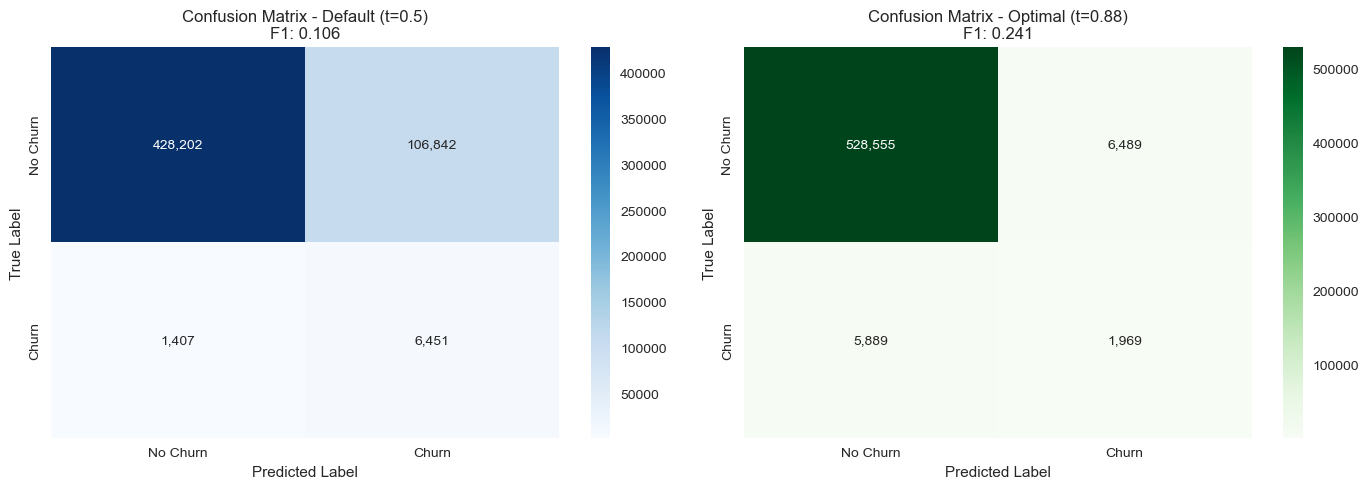


✓ Saved: figures\test_confusion_matrices.png


In [12]:
# Cell 12: Final Evaluation on Test Set
logger.info("\n" + "="*60)
logger.info("FINAL EVALUATION ON TEST SET")
logger.info("="*60)

# Get predictions on test set
y_test_pred_proba = model.predict_proba(test_pool)[:, 1]
y_test_pred_default = model.predict(test_pool)
y_test_pred_optimal = (y_test_pred_proba >= optimal_threshold).astype(int)

# Calculate metrics - Default threshold
test_auc = roc_auc_score(y_test, y_test_pred_proba)
test_gini = 2 * test_auc - 1  # GINI coefficient
test_prauc = average_precision_score(y_test, y_test_pred_proba)

# Metrics at default threshold (0.5)
default_f1 = f1_score(y_test, y_test_pred_default)
default_precision = precision_score(y_test, y_test_pred_default)
default_recall = recall_score(y_test, y_test_pred_default)
default_cm = confusion_matrix(y_test, y_test_pred_default)

# Metrics at optimal threshold
optimal_test_f1 = f1_score(y_test, y_test_pred_optimal)
optimal_test_precision = precision_score(y_test, y_test_pred_optimal)
optimal_test_recall = recall_score(y_test, y_test_pred_optimal)
optimal_test_cm = confusion_matrix(y_test, y_test_pred_optimal)

logger.info(f"\nTest Set Metrics:")
logger.info(f"  ROC-AUC: {test_auc:.4f}")
logger.info(f"  GINI: {test_gini:.4f}")
logger.info(f"  PR-AUC: {test_prauc:.4f}")

logger.info(f"\nDefault Threshold (0.5):")
logger.info(f"  F1: {default_f1:.4f}, Precision: {default_precision:.4f}, Recall: {default_recall:.4f}")
logger.info(f"  TN: {default_cm[0,0]:,}, FP: {default_cm[0,1]:,}")
logger.info(f"  FN: {default_cm[1,0]:,}, TP: {default_cm[1,1]:,}")

logger.info(f"\nOptimal Threshold ({optimal_threshold:.3f}):")
logger.info(f"  F1: {optimal_test_f1:.4f}, Precision: {optimal_test_precision:.4f}, Recall: {optimal_test_recall:.4f}")
logger.info(f"  TN: {optimal_test_cm[0,0]:,}, FP: {optimal_test_cm[0,1]:,}")
logger.info(f"  FN: {optimal_test_cm[1,0]:,}, TP: {optimal_test_cm[1,1]:,}")

print(f"\n" + "="*60)
print(f"FINAL TEST RESULTS")
print(f"="*60)
print(f"\nROC-AUC: {test_auc:.4f}")
print(f"GINI: {test_gini:.4f}")
print(f"PR-AUC: {test_prauc:.4f}")
print(f"\nOptimal Threshold ({optimal_threshold:.3f}):")
print(f"  F1: {optimal_test_f1:.4f}")
print(f"  Precision: {optimal_test_precision:.4f}")
print(f"  Recall: {optimal_test_recall:.4f}")

# Detailed classification report
print(f"\nClassification Report (optimal threshold):")
print(classification_report(y_test, y_test_pred_optimal, target_names=['No Churn', 'Churn']))

# Visualize confusion matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Default threshold
sns.heatmap(default_cm, annot=True, fmt=',d', cmap='Blues', ax=axes[0],
           xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
axes[0].set_title(f'Confusion Matrix - Default (t=0.5)\nF1: {default_f1:.3f}')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

# Optimal threshold
sns.heatmap(optimal_test_cm, annot=True, fmt=',d', cmap='Greens', ax=axes[1],
           xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
axes[1].set_title(f'Confusion Matrix - Optimal (t={optimal_threshold:.2f})\nF1: {optimal_test_f1:.3f}')
axes[1].set_ylabel('True Label')
axes[1].set_xlabel('Predicted Label')

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'test_confusion_matrices.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"\n✓ Saved: {config.FIGURES_DIR / 'test_confusion_matrices.png'}")


INFO - 
INFO - FEATURE IMPORTANCE ANALYSIS
INFO - ============================================================
INFO - ✓ Feature importance saved to models\feature_importance.csv
INFO - 
Top 20 Most Important Features:
INFO -   avg_activity_6m: 26.1318
INFO -   assets_trend_6m: 11.1431
INFO -   products_volatility_6m: 10.5079
INFO -   last_month_pl_amount: 10.4647
INFO -   roa_6m: 5.2421
INFO -   months_with_rko_pl_6m: 3.2787
INFO -   total_core_banking_income_6m: 2.6009
INFO -   income_cv_6m: 2.5355
INFO -   products_change_6m: 2.4488
INFO -   total_lending_ip_pl_6m: 2.1379
INFO -   total_core_banking_pl_6m: 2.1376
INFO -   total_lending_pl_6m: 1.9987
INFO -   assets_cv_6m: 1.9700
INFO -   pl_amount_trend_6m: 1.6990
INFO -   total_pl_amount_6m: 1.6308
INFO -   pl_cv_6m: 1.1930
INFO -   total_rko_pl_6m: 1.1414
INFO -   income_trend_6m: 1.1012
INFO -   declining_assets: 0.8881
INFO -   avg_pl_product_count_l2_6m: 0.8690

✓ Feature importance calculated

Top 10 Features:
                 

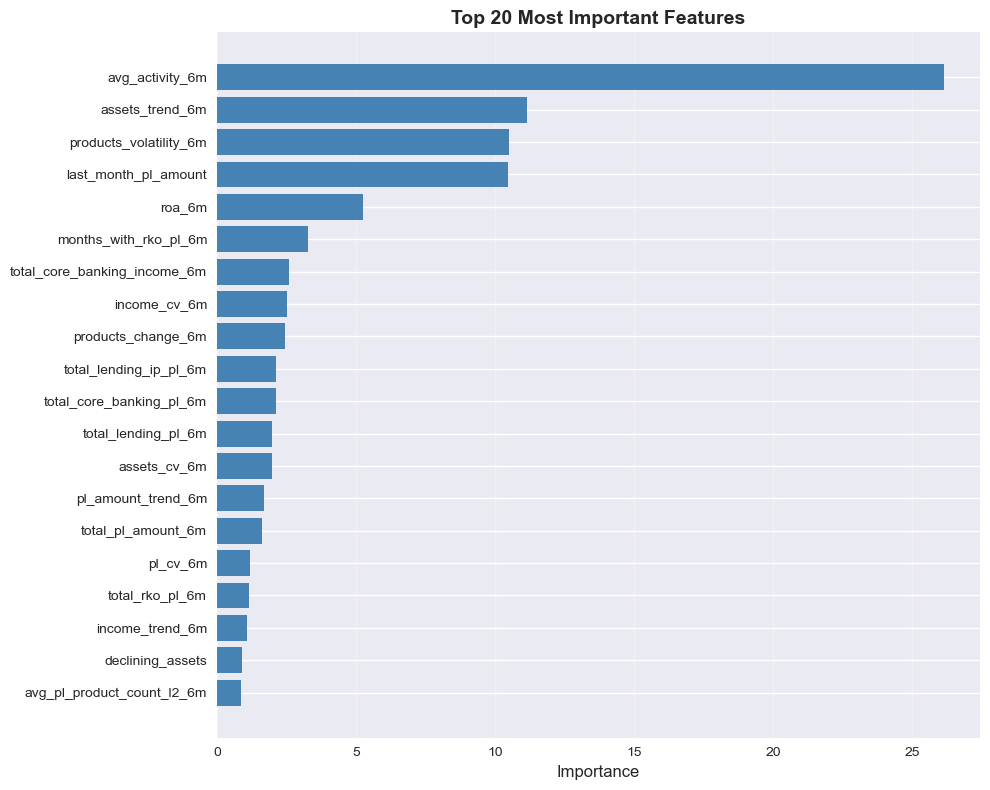

✓ Saved: figures\feature_importance.png


In [13]:
# Cell 13: Feature Importance Analysis
logger.info("\n" + "="*60)
logger.info("FEATURE IMPORTANCE ANALYSIS")
logger.info("="*60)

# Get feature importance
feature_importance = model.get_feature_importance(train_pool)
feature_names = X_train.columns

# Create DataFrame
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

# Save to file
importance_path = config.MODEL_DIR / config.FEATURE_IMPORTANCE_FILE
importance_df.to_csv(importance_path, index=False)
logger.info(f"✓ Feature importance saved to {importance_path}")

# Log top features
logger.info(f"\nTop 20 Most Important Features:")
for idx, row in importance_df.head(20).iterrows():
    logger.info(f"  {row['feature']}: {row['importance']:.4f}")

print(f"\n✓ Feature importance calculated")
print(f"\nTop 10 Features:")
print(importance_df.head(10).to_string(index=False))

# Visualize top 20 features
fig, ax = plt.subplots(figsize=(10, 8))
top_n = 20
top_features = importance_df.head(top_n)

ax.barh(range(top_n), top_features['importance'], color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(top_features['feature'])
ax.invert_yaxis()
ax.set_xlabel('Importance', fontsize=12)
ax.set_title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig(config.FIGURES_DIR / 'feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()
print(f"✓ Saved: {config.FIGURES_DIR / 'feature_importance.png'}")


In [14]:
importance_df.reset_index(drop=True).to_excel("features.xlsx")

In [15]:
# Cell 14: Save Model and Metadata
logger.info("\n" + "="*60)
logger.info("SAVING MODEL AND METADATA")
logger.info("="*60)

# Save CatBoost model
model_path = config.MODEL_DIR / config.MODEL_FILE
model.save_model(model_path)
logger.info(f"✓ Model saved to {model_path}")

# Create comprehensive metadata
model_metadata = {
    'model_info': {
        'model_type': 'CatBoost',
        'library_version': model.get_param('used_ram_limit'),
        'training_date': datetime.now().isoformat(),
        'best_iteration': int(model.best_iteration_),
        'best_score': float(model.best_score_['validation']['AUC'])
    },
    'data_info': {
        'train_samples': len(X_train),
        'val_samples': len(X_val),
        'test_samples': len(X_test),
        'n_features': len(X_train.columns),
        'feature_names': X_train.columns.tolist(),
        'categorical_features': categorical_features,
        'categorical_indices': cat_indices
    },
    'class_balance': {
        'train_churn_rate': float(churn_rate_train),
        'val_churn_rate': float(churn_rate_val),
        'imbalance_ratio': float(class_dist_train[0] / class_dist_train[1]),
        'scale_pos_weight': float(scale_pos_weight),
        'used_class_weights': config.USE_CLASS_WEIGHTS,
        'class_weight_0': float(class_weight_0) if config.USE_CLASS_WEIGHTS else None,
        'class_weight_1': float(class_weight_1) if config.USE_CLASS_WEIGHTS else None
    },
    'model_parameters': catboost_params,
    'threshold_tuning': {
        'optimal_threshold': float(optimal_threshold),
        'tuning_metric': config.THRESHOLD_METRIC,
        'optimal_score': float(optimal_score)
    },
    'validation_metrics': {
        'roc_auc': float(val_auc),
        'gini': float(val_gini),
        'pr_auc': float(val_prauc),
        'default_threshold': {
            'f1': float(val_f1),
            'precision': float(val_precision),
            'recall': float(val_recall)
        },
        'optimal_threshold': {
            'f1': float(optimal_f1),
            'precision': float(optimal_precision),
            'recall': float(optimal_recall)
        }
    },
    'test_metrics': {
        'roc_auc': float(test_auc),
        'gini': float(test_gini),
        'pr_auc': float(test_prauc),
        'default_threshold': {
            'f1': float(default_f1),
            'precision': float(default_precision),
            'recall': float(default_recall)
        },
        'optimal_threshold': {
            'f1': float(optimal_test_f1),
            'precision': float(optimal_test_precision),
            'recall': float(optimal_test_recall)
        }
    }
}

# Save metadata
metadata_path = config.MODEL_DIR / config.MODEL_METADATA
with open(metadata_path, 'w') as f:
    json.dump(model_metadata, f, indent=2)

logger.info(f"✓ Metadata saved to {metadata_path}")

print(f"\n✓ Model and metadata saved")
print(f"  Model: {model_path}")
print(f"  Metadata: {metadata_path}")
print(f"  Feature importance: {importance_path}")


INFO - 
INFO - SAVING MODEL AND METADATA
INFO - ============================================================
INFO - ✓ Model saved to models\catboost_churn_model.cbm
INFO - ✓ Metadata saved to models\model_metadata.json

✓ Model and metadata saved
  Model: models\catboost_churn_model.cbm
  Metadata: models\model_metadata.json
  Feature importance: models\feature_importance.csv


INFO - 
INFO - PRODUCTION DATA SCORING
INFO - ============================================================
INFO - Loading production data from output\prod_processed.csv
INFO -   Production data shape: (206770, 124)
INFO - Converting categorical features to string...
INFO -   ✓ Converted segment_group to string: 3 unique values
INFO -   ✓ Converted obs_month to string: 1 unique values
INFO -   ✓ Converted obs_quarter to string: 1 unique values
INFO - Creating CatBoost Pool for production data...
INFO - ✓ Production Pool created successfully
INFO - ✓ Production predictions saved to models\production_predictions.csv
INFO -   Predicted churners: 27,775 (13.43%)

✓ Production predictions complete
  Total clients: 206,770
  Predicted churners: 27,775 (13.43%)
  Results saved to: models\production_predictions.csv


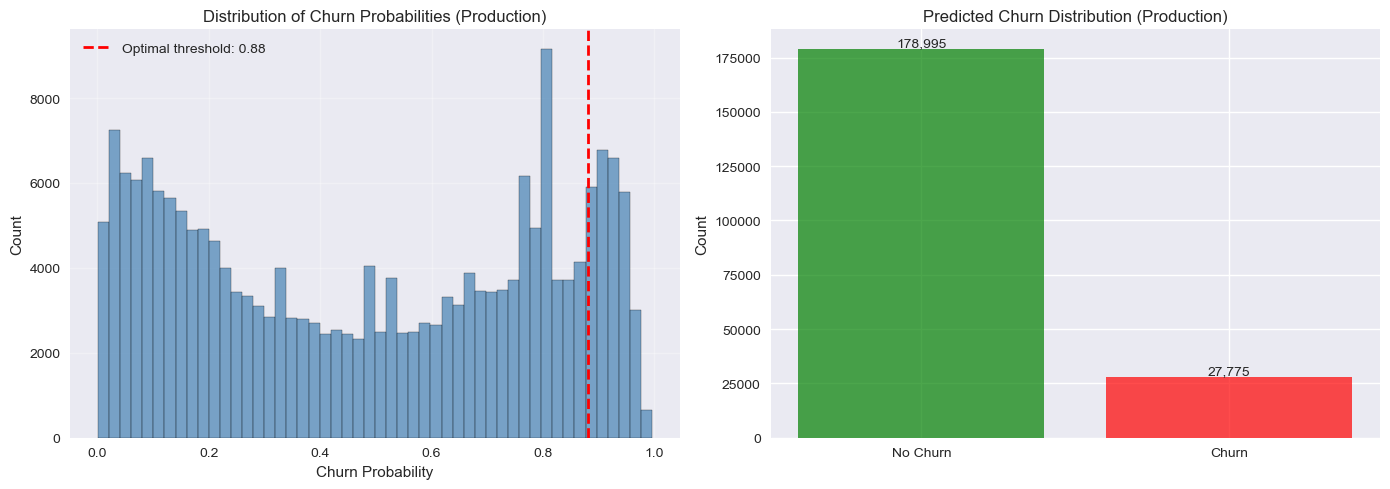

✓ Saved: figures\production_predictions.png


In [16]:
# Cell 15: Predictions on Production Data (if available)
logger.info("\n" + "="*60)
logger.info("PRODUCTION DATA SCORING")
logger.info("="*60)

prod_path = config.get_prod_path()

if prod_path.exists():
    logger.info(f"Loading production data from {prod_path}")
    prod_df = pd.read_csv(prod_path, delimiter=config.DELIMITER)
    logger.info(f"  Production data shape: {prod_df.shape}")
    
    # Prepare production data
    prod_feature_cols = [col for col in prod_df.columns 
                        if col not in config.ID_COLUMNS]
    X_prod = prod_df[prod_feature_cols].copy()
    
    # CRITICAL FIX: Convert categorical features to string type BEFORE creating Pool
    logger.info("Converting categorical features to string...")
    for cat_feat in categorical_features:
        if cat_feat in X_prod.columns:
            # Handle both numeric and already-string values
            X_prod[cat_feat] = X_prod[cat_feat].fillna('missing')  # Fill NaN first
            X_prod[cat_feat] = X_prod[cat_feat].astype(str)  # Convert to string
            X_prod[cat_feat] = X_prod[cat_feat].replace('nan', 'missing')  # Replace 'nan' strings
            logger.info(f"  ✓ Converted {cat_feat} to string: {X_prod[cat_feat].nunique()} unique values")
        else:
            logger.warning(f"  ⚠ Categorical feature {cat_feat} not found in production data")
    
    logger.info("Creating CatBoost Pool for production data...")
    
    # Verify all categorical features are strings before creating Pool
    for cat_feat in categorical_features:
        if cat_feat in X_prod.columns:
            if X_prod[cat_feat].dtype != 'object':
                logger.error(f"  ✗ {cat_feat} is still {X_prod[cat_feat].dtype}, not string!")
                raise ValueError(f"Failed to convert {cat_feat} to string")
    
    # Create Pool
    prod_pool = Pool(
        data=X_prod,
        cat_features=cat_indices
    )
    
    logger.info("✓ Production Pool created successfully")
    
    # Get predictions
    prod_pred_proba = model.predict_proba(prod_pool)[:, 1]
    prod_pred_optimal = (prod_pred_proba >= optimal_threshold).astype(int)
    
    # Add predictions to dataframe
    prod_results = prod_df[config.ID_COLUMNS].copy()
    prod_results['churn_probability'] = prod_pred_proba
    prod_results['churn_prediction'] = prod_pred_optimal
    prod_results['optimal_threshold'] = optimal_threshold
    
    # Save results
    results_path = config.MODEL_DIR / 'production_predictions.csv'
    prod_results.to_csv(results_path, index=False, sep='|')
    
    logger.info(f"✓ Production predictions saved to {results_path}")
    logger.info(f"  Predicted churners: {prod_pred_optimal.sum():,} ({prod_pred_optimal.mean()*100:.2f}%)")
    
    print(f"\n✓ Production predictions complete")
    print(f"  Total clients: {len(prod_results):,}")
    print(f"  Predicted churners: {prod_pred_optimal.sum():,} ({prod_pred_optimal.mean()*100:.2f}%)")
    print(f"  Results saved to: {results_path}")
    
    # Show distribution of probabilities
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Histogram of probabilities
    axes[0].hist(prod_pred_proba, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
    axes[0].axvline(optimal_threshold, color='red', linestyle='--', linewidth=2,
                   label=f'Optimal threshold: {optimal_threshold:.2f}')
    axes[0].set_xlabel('Churn Probability')
    axes[0].set_ylabel('Count')
    axes[0].set_title('Distribution of Churn Probabilities (Production)')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Predicted classes
    pred_counts = pd.Series(prod_pred_optimal).value_counts()
    axes[1].bar(['No Churn', 'Churn'], 
               [pred_counts.get(0, 0), pred_counts.get(1, 0)],
               color=['green', 'red'], alpha=0.7)
    axes[1].set_ylabel('Count')
    axes[1].set_title('Predicted Churn Distribution (Production)')
    for i, v in enumerate([pred_counts.get(0, 0), pred_counts.get(1, 0)]):
        axes[1].text(i, v, f'{v:,}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig(config.FIGURES_DIR / 'production_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✓ Saved: {config.FIGURES_DIR / 'production_predictions.png'}")
    
else:
    logger.warning(f"⚠ Production file not found: {prod_path}")
    print(f"\n⚠ Production file not found - skipping production scoring")

In [17]:
# Cell 16: Training Summary
logger.info("\n" + "="*60)
logger.info("TRAINING PIPELINE COMPLETED")
logger.info("="*60)

print("\n" + "="*60)
print("✓ CATBOOST TRAINING COMPLETE - SUMMARY")
print("="*60)

print(f"\n{'Dataset':<15} {'Samples':<12} {'Churn Rate':<12}")
print("-" * 60)
print(f"{'Train':<15} {len(X_train):<12,} {churn_rate_train*100:<12.2f}%")
print(f"{'Validation':<15} {len(X_val):<12,} {churn_rate_val*100:<12.2f}%")
print(f"{'Test':<15} {len(X_test):<12,} {(y_test.mean()*100):<12.2f}%")

print(f"\n{'Metric':<20} {'Validation':<15} {'Test':<15}")
print("-" * 60)
print(f"{'ROC-AUC':<20} {val_auc:<15.4f} {test_auc:<15.4f}")
print(f"{'GINI':<20} {val_gini:<15.4f} {test_gini:<15.4f}")
print(f"{'PR-AUC':<20} {val_prauc:<15.4f} {test_prauc:<15.4f}")

print(f"\n{'Optimal Threshold: ' + str(optimal_threshold):<40}")
print("-" * 60)
print(f"{'F1 Score':<20} {optimal_f1:<15.4f} {optimal_test_f1:<15.4f}")
print(f"{'Precision':<20} {optimal_precision:<15.4f} {optimal_test_precision:<15.4f}")
print(f"{'Recall':<20} {optimal_recall:<15.4f} {optimal_test_recall:<15.4f}")

print(f"\nClass Imbalance Handling:")
print(f"  Imbalance ratio: {class_dist_train[0]/class_dist_train[1]:.1f}:1")
print(f"  Used class weights: {config.USE_CLASS_WEIGHTS}")
if config.USE_CLASS_WEIGHTS:
    print(f"    Class 0 weight: {class_weight_0:.4f}")
    print(f"    Class 1 weight: {class_weight_1:.4f}")
if config.USE_SCALE_POS_WEIGHT and not config.USE_CLASS_WEIGHTS:
    print(f"  Scale pos weight: {scale_pos_weight:.2f}")

print(f"\nModel Details:")
print(f"  Best iteration: {model.best_iteration_}")
print(f"  Number of features: {len(X_train.columns)}")
print(f"  Categorical features: {len(categorical_features)}")

print(f"\nOutput Files:")
print(f"  Model: {config.MODEL_DIR / config.MODEL_FILE}")
print(f"  Metadata: {config.MODEL_DIR / config.MODEL_METADATA}")
print(f"  Feature importance: {config.MODEL_DIR / config.FEATURE_IMPORTANCE_FILE}")
print(f"  Figures: {config.FIGURES_DIR}")
print(f"  Logs: {config.LOG_DIR}")

print("\n" + "="*60)
print("✓ MODEL READY FOR DEPLOYMENT")
print("="*60)

print("\nNext Steps:")
print("1. Review model performance metrics")
print("2. Analyze feature importance")
print("3. Review threshold tuning results")
print("4. Deploy model with optimal threshold")
print(f"5. Use threshold = {optimal_threshold:.3f} for predictions")
print("6. Monitor model performance in production")

logger.info("\n" + "="*60)
logger.info("ALL TASKS COMPLETED SUCCESSFULLY")
logger.info("="*60)

INFO - 
INFO - TRAINING PIPELINE COMPLETED
INFO - ============================================================

✓ CATBOOST TRAINING COMPLETE - SUMMARY

Dataset         Samples      Churn Rate  
------------------------------------------------------------
Train           2,153,407    1.44        %
Validation      531,880      1.77        %
Test            542,902      1.45        %

Metric               Validation      Test           
------------------------------------------------------------
ROC-AUC              0.9066          0.8917         
GINI                 0.8132          0.7835         
PR-AUC               0.2160          0.1817         

Optimal Threshold: 0.8799999999999996   
------------------------------------------------------------
F1 Score             0.3003          0.2414         
Precision            0.2735          0.2328         
Recall               0.3330          0.2506         

Class Imbalance Handling:
  Imbalance ratio: 68.2:1
  Used class weights: True
